In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_truncated_normal_observation import ARTruncatedNormalObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import time

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj0 = rendered_data[0]

In [4]:
from project_ssms.momentum_utils import filter_traj_by_speed

In [5]:
f_traj = filter_traj_by_speed(traj0, q1=0.99, q2=0.99)

In [6]:
arena_xmin = 10
arena_xmax = 320

arena_ymin = -10
arena_ymax = 390

# model

In [7]:
K = 4
D = 4
lags = 1

bounds = np.array([[arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5], 
                   [arena_xmin - 5, arena_xmax + 5], [arena_ymin - 5, arena_ymax + 5]])

As = np.array([np.column_stack([np.identity(D), np.zeros((D, (lags-1) * D))]) for _ in range(K)])


In [8]:
torch.manual_seed(0)
np.random.seed(0)

tran = LinearTransformation(K=K, D=D, lags=lags, As=As)
observation = ARTruncatedNormalObservation(K=K, D=D, M=0, transformation=tran, bounds=bounds)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(f_traj, dtype=torch.float64)

In [9]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [10]:
T = 36000

In [11]:
model.log_likelihood(data)

tensor(-313751.2171, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [12]:
losses, optimizer = model.fit(data, method='adam', num_iters=3000, lr=0.005)

iter 2990 loss 229371.67: 100%|██████████| 3000/3000 [25:33<00:00,  1.91it/s] | 0/3000 [00:00<?, ?it/s]


In [29]:
losses_1, optimizer_1 = model.fit(data, method='adam', num_iters=2000, lr=0.001)

iter 1990 loss 228944.95: 100%|██████████| 2000/2000 [18:29<00:00,  2.06it/s] | 0/2000 [00:00<?, ?it/s]


In [ ]:
losses_2, optimizer_2 = model.fit(data, method='adam', num_iters=5000, lr=0.0005)

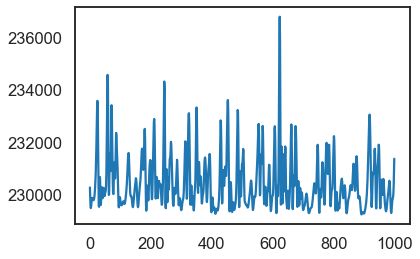

In [28]:
plt.plot(losses[2000:])

In [13]:
z = model.most_likely_states(data)

In [14]:
x_predict = k_step_prediction(model, z, data)

([], <a list of 0 Text yticklabel objects>)

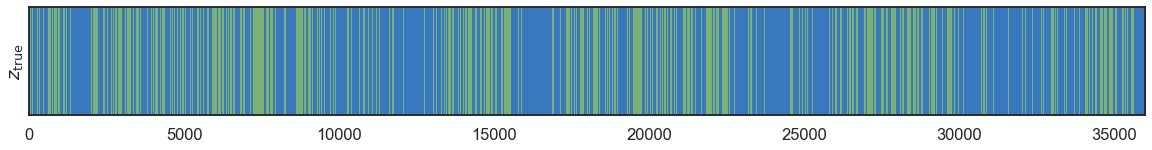

In [15]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

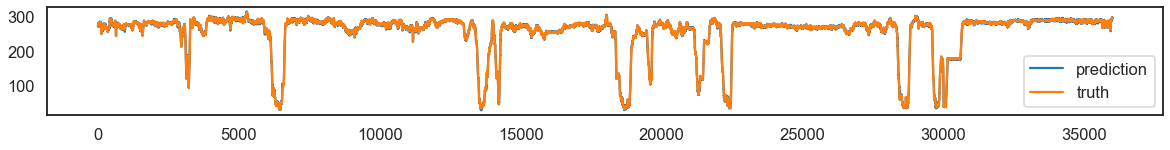

In [16]:
plt.figure(figsize=(20,2))

plt.plot(x_predict[:,0], label='prediction')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()

# check samples

In [17]:
sample_z, sample_x = model.sample(T)

([], <a list of 0 Text yticklabel objects>)

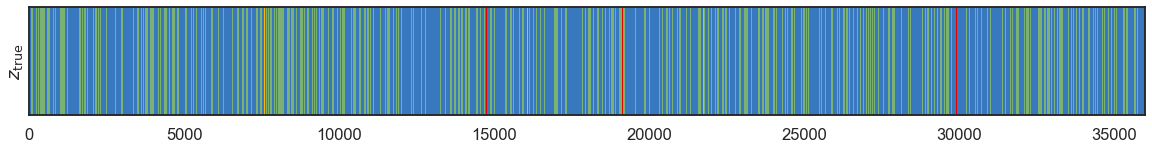

In [18]:
plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

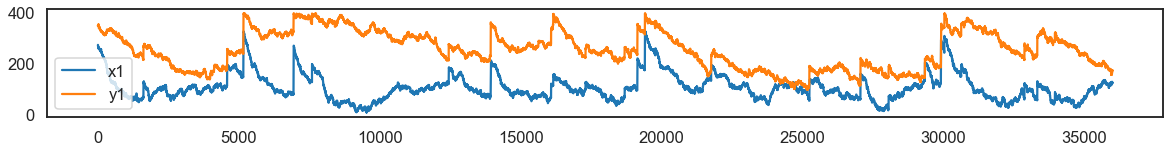

In [32]:
plt.figure(figsize=(20,2))

plt.plot(sample_x[:,0], label='x1')
plt.plot(sample_x[:,1], label='y1')
plt.legend()

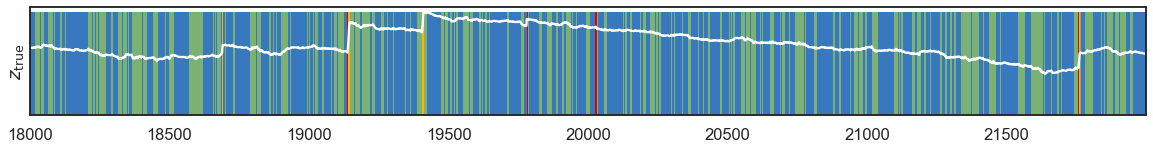

In [39]:
plot_range = np.arange(18000, 22000)

plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_ymin-10, arena_ymax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, sample_x[plot_range[0]:plot_range[-1]+1, 1], color='white');

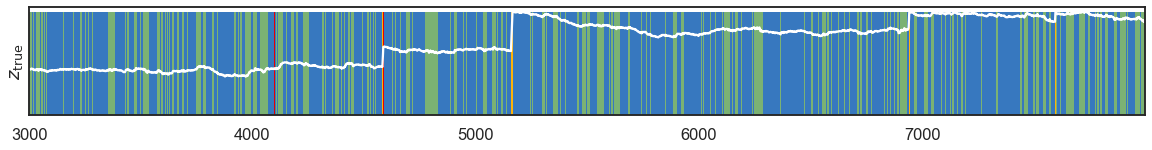

In [43]:
plot_range = np.arange(3000, 8000)

plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_ymin-10, arena_ymax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, sample_x[plot_range[0]:plot_range[-1]+1, 1], color='white');

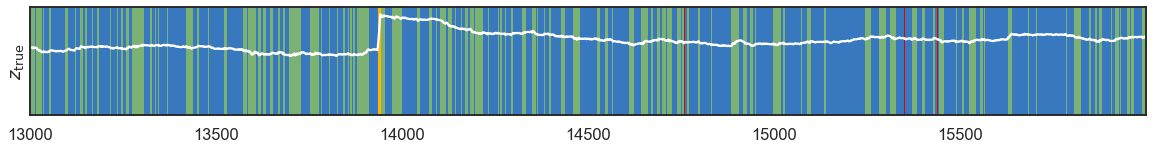

In [44]:
plot_range = np.arange(13000, 16000)

plt.figure(figsize=(20,2))
plt.imshow(sample_z[None,plot_range[0]:plot_range[-1]], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(plot_range[0], plot_range[-1], arena_ymin-10, arena_ymax))
plt.xlim(plot_range[0], plot_range[-1])
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

#plt.figure(figsize=(20,2))
plt.plot(plot_range, sample_x[plot_range[0]:plot_range[-1]+1, 1], color='white');

In [38]:
[sum(sample_z==k) for k in range(K)]

[23166, 86, 103, 12645]

Text(0.5, 1.0, 'ground truth')

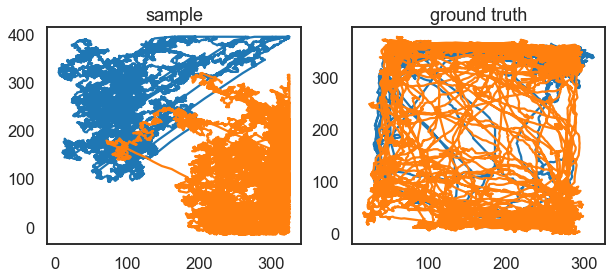

In [36]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(sample_x[:,0], sample_x[:,1])
plt.plot(sample_x[:,2], sample_x[:,3])
plt.title("sample")

plt.subplot(1,2,2)
plt.plot(data[:,0].numpy(), data[:,1].numpy())
plt.plot(data[:,2].numpy(), data[:,3].numpy())
plt.title("ground truth")

# check speed

In [22]:
speed_sample_x = np.diff(sample_x, axis=0)

In [23]:
speed_x = np.diff(data.numpy(), axis=0)

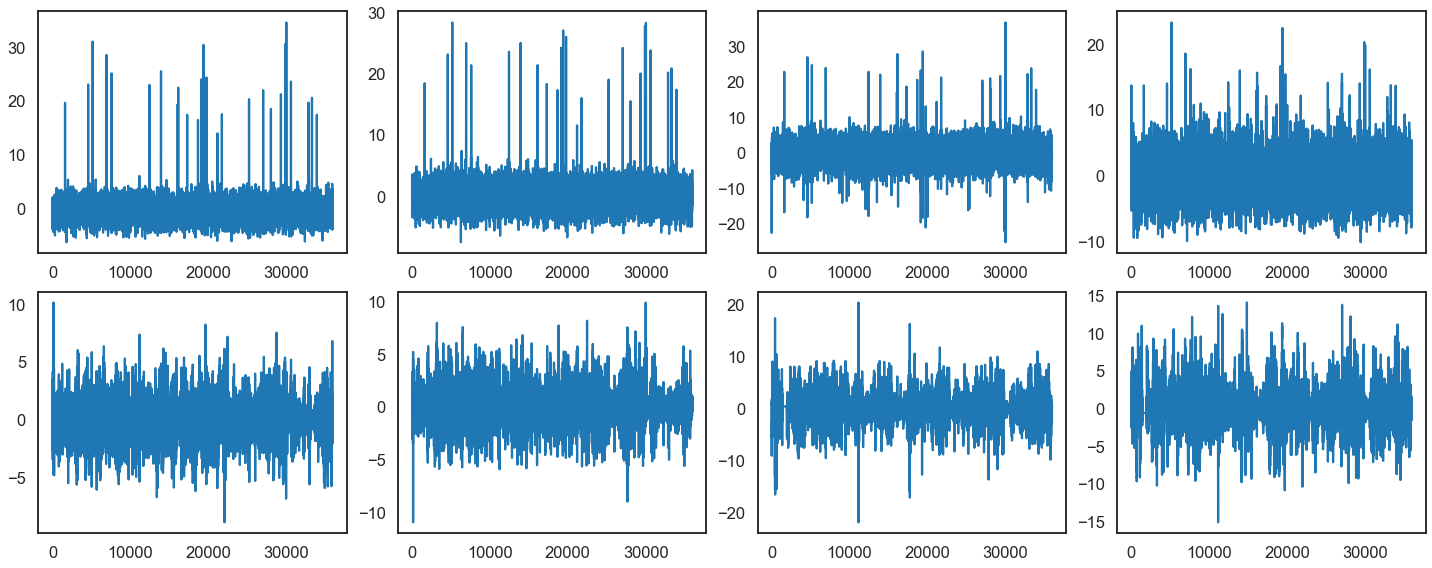

In [24]:
plt.figure(figsize=(20,8))

plt.subplot(2,4,1)
plt.plot(speed_sample_x[:,0])
plt.subplot(2,4,2)
plt.plot(speed_sample_x[:,1])
plt.subplot(2,4,3)
plt.plot(speed_sample_x[:,2])
plt.subplot(2,4,4)
plt.plot(speed_sample_x[:,3])

plt.subplot(2,4,5)
plt.plot(speed_x[:,0])
plt.subplot(2,4,6)
plt.plot(speed_x[:,1])
plt.subplot(2,4,7)
plt.plot(speed_x[:,2])
plt.subplot(2,4,8)
plt.plot(speed_x[:,3])

plt.tight_layout()

In [ ]:
diff = x_predict - data.numpy()

In [25]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7156, 0.6859, 0.8819, 0.8058],
        [1.0500, 1.0319, 1.0364, 1.0433],
        [1.0444, 1.0464, 1.0542, 1.0456],
        [1.6371, 1.7945, 2.8266, 2.8996]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [ ]:
z[np.where(diff[:,0]>10)]

In [ ]:
diff[0]